In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import os 
os.chdir('/media/pemfir/Data/UdacityProjects/Data/P5-Exercises/')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


/home/pemfir/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loading images ....


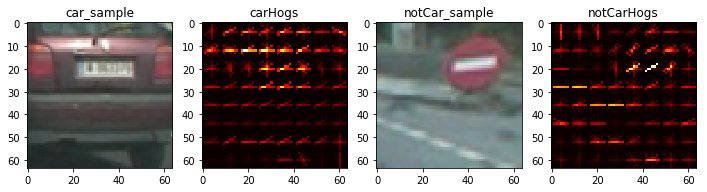

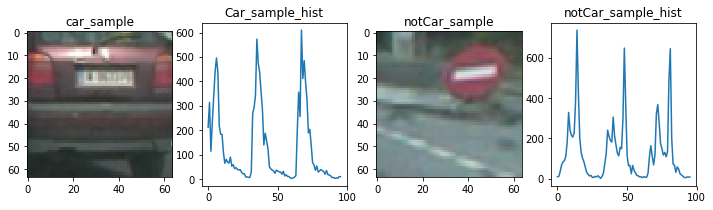

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
def visualize(fig,rows,cols,imgs,titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 2:
            plt.plot(img)
            plt.title(titles[i])
        elif img_dims < 3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
    
# Read in cars and notcars
print('loading images ....')
images_nonvehicles = glob.glob('./bigSet/non-vehicles/*/*.png')
images_vehicles = glob.glob('./bigSet/vehicles/*/*.png')
cars = []
notcars = []
for image in images_nonvehicles:
    notcars.append(image)
for image in images_vehicles:
    cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 100
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

car_sample = np.random.randint(0,len(cars))
car_sample = mpimg.imread(cars[car_sample])

notCar_sample = np.random.randint(0,len(notcars))
notCar_sample = mpimg.imread(notcars[notCar_sample])


### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


_, carHogs = get_hog_features(car_sample[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
_, notCarHogs = get_hog_features(notCar_sample[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

images = [car_sample,carHogs,notCar_sample,notCarHogs]
titles = ['car_sample','carHogs','notCar_sample','notCarHogs']
fig = plt.figure(figsize=(12,3))
visualize(fig,1,4,images,titles)

car_sample_hist = color_hist(car_sample, nbins=32)
notCar_sample_hist = color_hist(notCar_sample, nbins=32)
images = [car_sample,car_sample_hist,notCar_sample,notCar_sample_hist]
titles = ['car_sample','Car_sample_hist','notCar_sample','notCar_sample_hist']
fig = plt.figure(figsize=(12,3))
visualize(fig,1,4,images,titles)


# os.chdir('/media/pemfir/Data/UdacityProjects/Code/P5-VehicleDetection/test_images/')
# for image,title in zip(images,titles): 
#     mpimg.imsave(title,image.astype('float'))

In [16]:
import os 
os.chdir('/media/pemfir/Data/UdacityProjects/Data/P5-Exercises/')
print('loading images ....')
images_nonvehicles = glob.glob('./bigSet/non-vehicles/*/*.png')
images_vehicles = glob.glob('./bigSet/vehicles/*/*.png')
cars = []
notcars = []
for image in images_nonvehicles:
    notcars.append(image)
for image in images_vehicles:
    cars.append(image)

# sample_size = 20000
cars = cars
notcars = notcars

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
# svc = LinearSVC()
svc = LinearSVC(loss='l2', penalty='l1', dual=False,C = 10)
# svc = LinearSVC(C = 1E-7)
# from sklearn import svm 
# svc = svm.SVC(kernel= 'poly')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()





loading images ....
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
69.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


loading images ....
number of windows 350


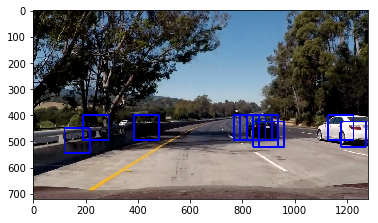

number of windows 350


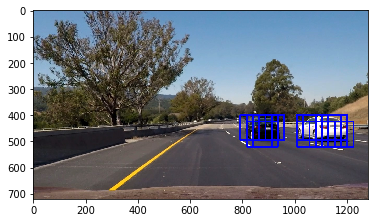

number of windows 350


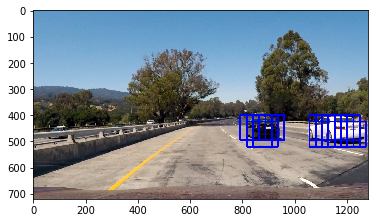

number of windows 350


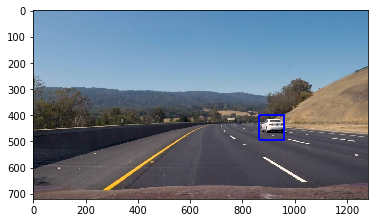

number of windows 350


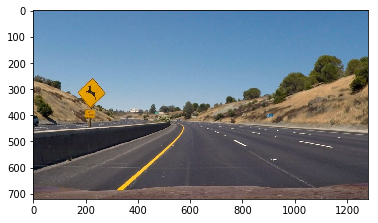

number of windows 350


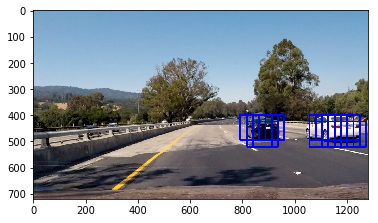

In [17]:
import os 
os.chdir('/media/pemfir/Data/UdacityProjects/Code/P5-VehicleDetection/test_images/')
print('loading images ....')
testExamples = glob.glob('./*.jpg')
examples = []
for image in testExamples:
    examples.append(image)


    image = mpimg.imread(image)
    y_start_stop = [int(image.shape[0]*0.5), image.shape[0]-10] # Min and max in y to search in slide_window()
    y_start_stop = [400, 656] # Min and max in y to search in slide_window()
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
#     print(np.min(img),np.max(img))

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96,96), xy_overlap=(0.75, 0.75))
    
    print('number of windows', len(windows))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    plt.show()


loading images ....
[MoviePy] >>>> Building video submission_video.mp4
[MoviePy] Writing video submission_video.mp4


100%|██████████| 176/176 [03:41<00:00,  1.30s/it]     | 1/176 [00:01<03:39,  1.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: submission_video.mp4 

CPU times: user 21min 39s, sys: 7.72 s, total: 21min 46s
Wall time: 3min 41s
loading images ....


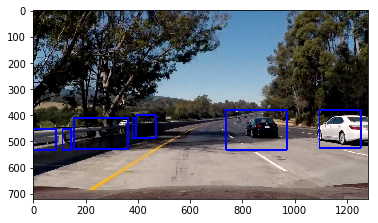

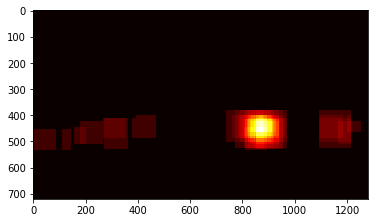

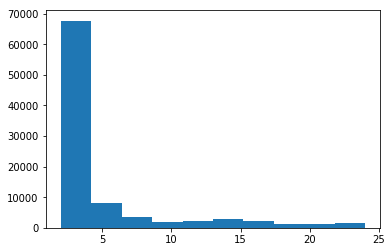

<class 'numpy.ndarray'> (720, 1280)


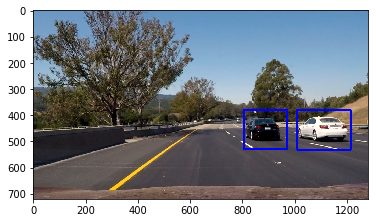

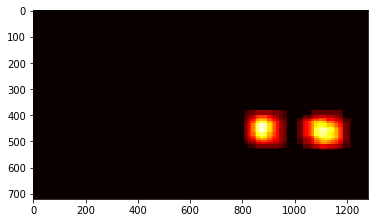

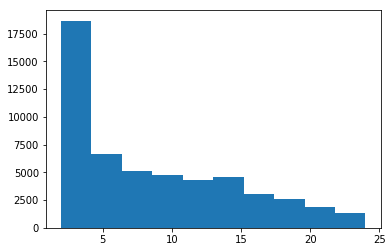

<class 'numpy.ndarray'> (720, 1280)


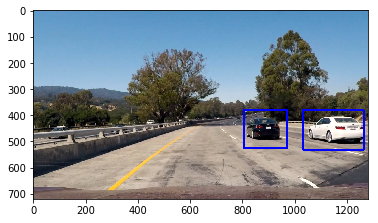

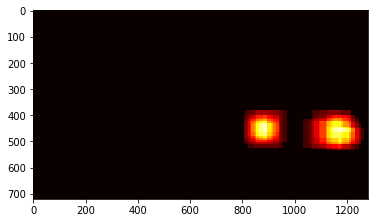

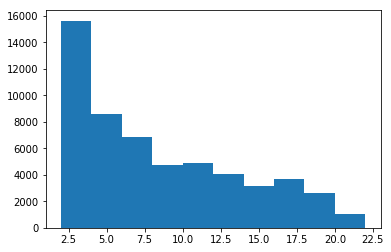

<class 'numpy.ndarray'> (720, 1280)


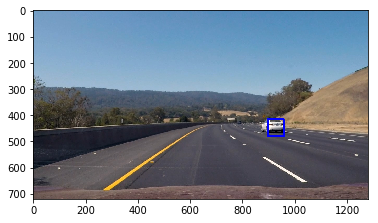

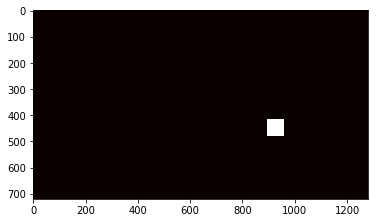

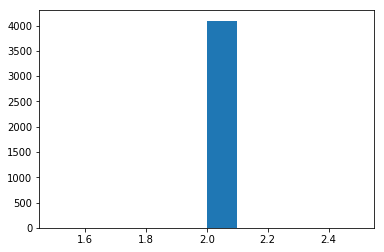

<class 'numpy.ndarray'> (720, 1280)


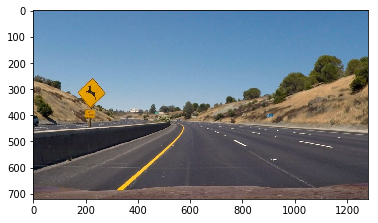

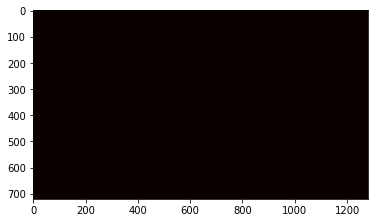

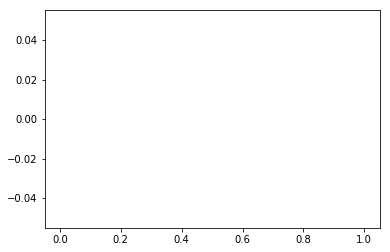

<class 'numpy.ndarray'> (720, 1280)


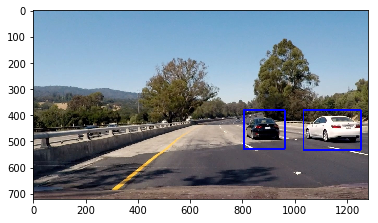

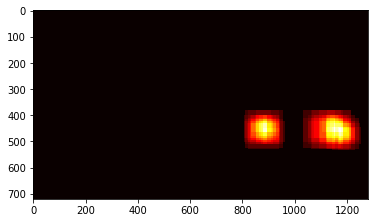

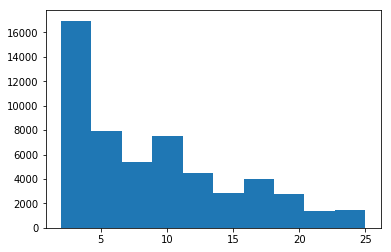

<class 'numpy.ndarray'> (720, 1280)


In [29]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2


img = mpimg.imread('/media/pemfir/Data/UdacityProjects/Code/P5-Exercises/bbox-example-image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    box_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    # we change the image size and enlarge it 
    # instead of changing the sliding window sizes, 
    # we keep that constant but scale up and down the image itself. 
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    # hold the number of cells in the hogs transformation 
    # number of blocks is related to number of cells. Consider a block on an image
    # we move the block to the right. When we do that we move the block as much as "one" cell to the right.
    # therefore, number of blocks is euqal to the number of cells in the image but a little less
    # consider you are sliding a block to the right, cell by cell, until you reach towards the end. 
    # number of blocks in each direction of the image = number of pixels in x / number of cells 
    # in a (128x128 image) and (8x8) cells we have (15x15) blocks in 15 in x and 15 in y direction 
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    # how many features being extracted per block in hogs tranformation 
    # number of features in each block = cells per block * features per cell 
    nfeat_per_block = orient*cell_per_block**2
    # 64 by 64 is our window size. (64x64) is the size of the training and test images that trained the classifier
    window = 64
    # number of blocks in each window. for example in a (64x64) image
    # with cells that contain 64 pixels (8x8) each block contains 2 cells. you can have 7 blocks.
    # note each block is shifted by one cell to the right for example when generating hogs features.
    # in a (64x64 window) and (8x8) cells we have (7x7) blocks in 7 in x and 7 in y direction
    nblocks_per_window = (window // pix_per_cell)-1 
    # move 2 cells to the right to create sliding windows ?
    # imagine a sliding windows of (64x64) you are sliding it across a test image, 2 cell (16 pixels at the itme)
    # the windows is made of 8 cells, you share 6 cells from the previous windows with the new one when you move
    # to the right by 2 cells to have your next (64x64) windows and that means window 1 and window 2, are 75% overlapping 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    # steps across hog array to extract features 
    # in an image of  (128x128 image , 15 overlapping blocks in each direction ), 
    # with window size of (64x64 window, 7 overlapping blocks in each direction) 
    # we have (15 - 7)/2 = 4 windows in total in each direction.  
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    # the idea is to calculate hogs for , for example (128x128 image) 
    # and apply sliding windows of size (64x64) to it 
    # output here is a feature_vec=False so it is an image 
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch that we are interested and then flattening them into a vector
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch (original image) so that we can apply hist and spatial sampling from it
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return draw_img,box_list
    

def box_generator(img,scaleVector,ystartVector,ystopVector):
    box_list = []
    for scale,ystart,ystop in zip(scaleVector,ystartVector,ystopVector):    
        out_img,box_list_scale = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list.extend(box_list_scale)
    return box_list



def final_image(image):
    global headmapHistory
    global counter 
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    import numpy as np
    import pickle
    import cv2
    from scipy.ndimage.measurements import label
    ystartVector = [380, 380, 400, 400]
    ystopVector = [650, 656, 650, 650]
    scaleVector = [2.3, 1.9, 1.4, 1]
    box_list = box_generator(image,scaleVector,ystartVector,ystopVector)

    # Read in image similar to one shown above 
#     image = mpimg.imread('/media/pemfir/Data/UdacityProjects/Code/P5-Exercises/bbox-example-image.jpg')
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    def add_heat(heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

    def apply_threshold(heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    forget_rate = 0.5
    
    if counter == 0: 
        headmapHistory = [heat]
        counter += 1
        heat = headmapHistory[0]
        heat = apply_threshold(heat,1.8)
    else:
        headmapHistory.append([heat])
        headmapHistory = headmapHistory[-15:]
        heat = [sum(i) for i in zip(*headmapHistory)][0]/len(headmapHistory)
        heat = apply_threshold(heat,1.8)
        
      # Apply threshold to help remove false positives        
#     headmapHistory = (1- forget_rate)*heat + forget_rate*headmapHistory
#     heat = apply_threshold(headmapHistory,2)


    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    if hearmapOn :
        return draw_img,heatmap
    else:
        return draw_img  


    
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

os.chdir('/media/pemfir/Data/UdacityProjects/Code/P5-VehicleDetection/test_images/')
print('loading images ....')
testExamples = glob.glob('./*.jpg')
## headmapHistory = np.zeros_like(mpimg.imread(testExamples[0])[:,:,0])
counter = 0
hearmapOn = False
os.chdir('/media/pemfir/Data/UdacityProjects/Code/P5-VehicleDetection/')
white_output = 'submission_video.mp4'
clip1 = VideoFileClip('whiteDisappear.mp4')
white_clip = clip1.fl_image(final_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)    



import os 
os.chdir('/media/pemfir/Data/UdacityProjects/Code/P5-VehicleDetection/test_images/')
print('loading images ....')
testExamples = glob.glob('./*.jpg')
hearmapOn = True
for image in testExamples:
    counter = 0
#     headmapHistory = np.zeros_like(mpimg.imread(testExamples[0])[:,:,0])
    image = mpimg.imread(image)
    image,heatmap = final_image(image)                  
    plt.imshow(image)
    plt.show()
    plt.imshow(heatmap,cmap='hot')
    plt.show()
    plt.hist(heatmap.ravel()[heatmap.ravel()>0],10)
    plt.show()
    print(type(heatmap),heatmap.shape)


# ystart = [380, 380, 400, 400]
# ystop = [650, 656, 650, 650]
# scale = [2.3, 1.9, 1.4, 1]
# cells_per_step = [1, 1, 2, 2]